In [6]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/adi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/adi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/adi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
df = pd.read_csv("swat-onboarding-main copy/src/data.csv", encoding = "ISO-8859-1", header = None)
df_unseen = pd.read_csv("swat-onboarding-main copy/src/stock_news.csv", header = None)

In [9]:
df.columns = ["Sentiment", "Text"]
#df_unseen.columns = ["index", "Text", "Date", "Stock"]
df_unseen.columns = ["index", "Text", "Sentiment"]
df_unseen.drop("index", axis = 1, inplace = True)
#df_unseen.drop("Date", axis = 1, inplace = True)
#df_unseen.drop("Stock", axis = 1, inplace = True)
df_unseen.drop(0, axis = 0, inplace = True)
df.dropna(inplace=True)
df_unseen.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df_unseen.drop_duplicates(inplace=True)

In [10]:
#Preprocessing 1
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
df["Text"] = df["Text"].str.lower()
df["Sentiment"] = df["Sentiment"].str.lower()
df["Text"] = df["Text"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
df["Text"] = df["Text"].apply(lambda x: nltk.word_tokenize(x))
df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])
df["Text"] = df["Text"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df["Text"] = df["Text"].apply(lambda x: " ".join(x))

In [11]:
#Preprocessing 2
df_unseen["Text"] = df_unseen["Text"].str.lower()
df_unseen["Sentiment"] = df_unseen["Sentiment"].str.lower()
df_unseen["Text"] = df_unseen["Text"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
df_unseen["Text"] = df_unseen["Text"].apply(lambda x: nltk.word_tokenize(x))
df_unseen['Text'] = df_unseen['Text'].apply(lambda x: [word for word in x if word not in stop_words])
df_unseen["Text"] = df_unseen["Text"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_unseen["Text"] = df_unseen["Text"].apply(lambda x: " ".join(x))

In [12]:
label_encoder = LabelEncoder()
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])
df_unseen["Sentiment"] = label_encoder.transform(df_unseen["Sentiment"])
#0 is negative, 1 is neutral, 2 is positive

In [13]:
"""
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
df_unseen["Sentiment"] = df_unseen["Sentiment"].str.lower()
def preprocess_text(text, stop_words, lemmatizer):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["Text"] = df["Text"].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))
df_unseen["Text"] = df_unseen["Text"].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))
"""


'\nstop_words = stopwords.words(\'english\')\nlemmatizer = WordNetLemmatizer()\ndf_unseen["Sentiment"] = df_unseen["Sentiment"].str.lower()\ndef preprocess_text(text, stop_words, lemmatizer):\n    text = text.lower()\n    text = re.sub(r"[^\\w\\s]", "", text)  # Remove punctuation\n    tokens = nltk.word_tokenize(text)\n    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]\n    return " ".join(tokens)\n\ndf["Text"] = df["Text"].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))\ndf_unseen["Text"] = df_unseen["Text"].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))\n'

In [14]:
#Train Test Split
x = df["Text"]
y = df["Sentiment"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1, random_state = 1)

classes = np.array([0, 1, 2])  # Negative, Neutral, Positive
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

In [15]:
#Logistic Regression Classification Pipeline
log_reg_clf = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('log_reg', LogisticRegression(class_weight=class_weight_dict, max_iter = 1000))
])

In [16]:
#Logistic Regression Training
log_reg_clf.fit(x_train, y_train)

x_pred_log_reg = log_reg_clf.predict(x_test)
print(classification_report(y_test, x_pred_log_reg))

unseen_x = df_unseen["Text"]
unseen_y = df_unseen["Sentiment"]

              precision    recall  f1-score   support

           0       0.64      0.68      0.66        57
           1       0.85      0.84      0.85       288
           2       0.71      0.70      0.71       139

    accuracy                           0.78       484
   macro avg       0.73      0.74      0.74       484
weighted avg       0.78      0.78      0.78       484



In [17]:
predictions = log_reg_clf.predict(unseen_x)
#print(predictions)
#print(df_unseen["Sentiment"].head(), df_unseen["Sentiment"].tail())

print(accuracy_score(list(df_unseen["Sentiment"]), predictions))

0.42323076923076924


In [18]:
"""
cm = confusion_matrix(x_test, x_pred_log_reg)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
"""

'\ncm = confusion_matrix(x_test, x_pred_log_reg)\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues")\nplt.xlabel("Predicted")\nplt.ylabel("Actual")\nplt.title("Confusion Matrix")\nplt.show()\n'

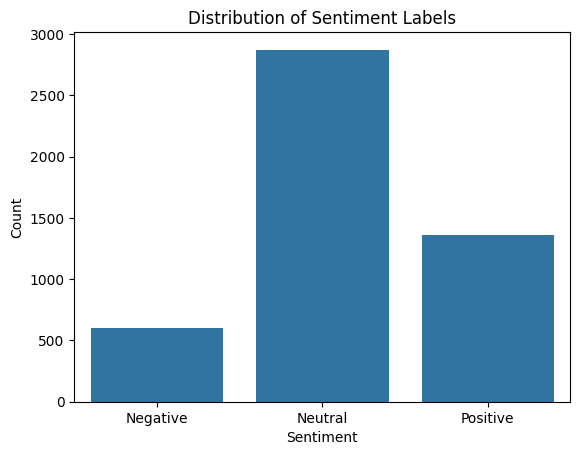

In [19]:
sentiment_counts = df["Sentiment"].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()